In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_group: "03_15_24_RandomCircles_VaryEnsembleSize"
    
calibration:
    metric_cfg_file: "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference/Calibration_Metrics.yaml"

options:
    add_baseline_rows: False 
    load_pixel_meters: False 
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    load_groupavg_metrics: False
    remove_shared_columns: False
    equal_rows_per_cfg_assert: True 

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.analyze_inf import load_cal_inference_stats

image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False
)

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 143856 -> 143856 rows.
Finished loading inference stats.
Log amounts: log.root                                                                                                      log_set                                              
/storage/vbutoi/scratch/ESE/inference/03_15_24_RandomCircles_VaryEnsembleSize/Shapes_Ensemble_LTS             20240315_105241-9OTD-c70a47c23f57d9bde037ccdfd01adc77    1377
                                                                                                              20240315_105244-1U0C-8d3ef70f3e03991a2b97d5710d456506    1377
                                                                                                              20240315_105247-JE46-5676a5bf02e712af1217cd109e8663fa    1377
                                                                                                              20240315_105249-BDAS-baed47781ab1e36b4b10d8a61c1a2d5e    1377
       

In [4]:
image_info_df['calibrator'].unique()

array(['Uncalibrated', 'TempScaling', 'LTS'], dtype=object)

## We are going to remove the case where there are very few pixels, cause unrealistic outliers.

In [5]:
# Sort the image_info_df by method name, so everything appears nicely
image_info_df = image_info_df.sort_values(by=['method_name', 'calibrator'])
# Make sure that the model_class 'Uncalibrated' is first
image_info_df['calibrator'] = image_info_df['calibrator'].astype('category')
image_info_df['calibrator'] = image_info_df['calibrator'].cat.reorder_categories([
    'Uncalibrated',
    'TempScaling', 
    # 'IBTS',
    'LTS'
])

In [6]:
# Select only the rows corresponding to group methods
image_info_df = image_info_df[image_info_df['model_type'] == 'group']

In [7]:
image_info_df['method_name'].unique()

array(['Ensemble (mean, probs)'], dtype=object)

In [8]:
image_info_df['method_name'] = image_info_df['method_name'].astype('category')
image_info_df['method_name'] = image_info_df['method_name'].cat.reorder_categories([
    # 'Average UNet',
    'Ensemble (mean, probs)', 
    # 'Ensemble (product, probs)', 
])

image_info_df['split'] = image_info_df['split'].astype('category')
image_info_df['split'] = image_info_df['split'].cat.reorder_categories([
    'val',
    'cal'
])

# Let's looks at the calibration scores of our models.

## ECE Metrics

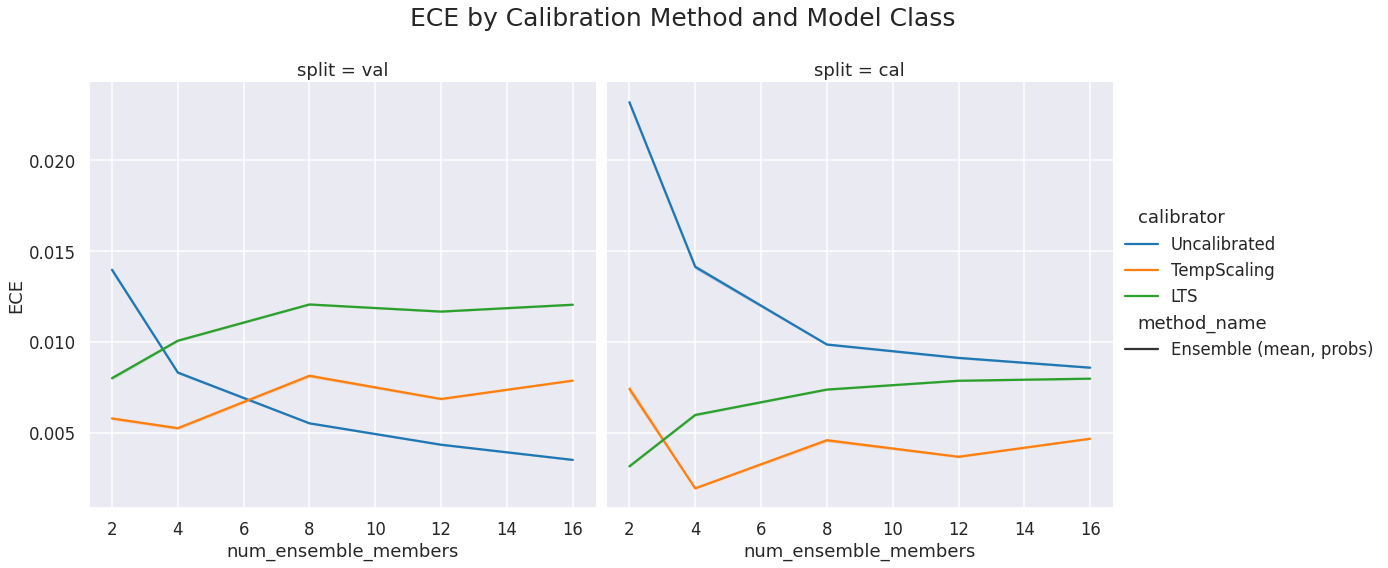

In [9]:
g = sns.relplot(
    data=image_info_df,
    x="num_ensemble_members",
    y="ECE",
    hue="calibrator",
    style="method_name",
    col="split",
    kind="line",
    height=8,
)
g.fig.suptitle("ECE by Calibration Method and Model Class", fontsize=25)
g.fig.subplots_adjust(top=0.85)

In [10]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="CW-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.001))
# g.fig.suptitle("CW-ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [11]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Uniform-CW-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.001))
# g.fig.suptitle("Uniform-CW-ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [12]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Edge-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.05))
# g.fig.suptitle("Edge ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [13]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="ECW-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.004))
# g.fig.suptitle("Edge CW-ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [14]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Uniform-ECW-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.05))
# g.fig.suptitle("Uniform ECW-ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

## ELM Metrics

In [15]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="ELM",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.001))
# g.fig.suptitle("ELM by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [16]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Edge-ELM",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.001))
# g.fig.suptitle("Edge-ELM by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [17]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Uniform-ELM",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.3))
# g.fig.suptitle("Uniform-ELM by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [18]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Uniform-Edge-ELM",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.3))
# g.fig.suptitle("Uniform-Edge-ELM by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

## Now we can look at the quality averages themselves, first looking slice-wise.

In [19]:
image_info_df["image_metric"].unique()

array(['Dice', 'HD95', 'BoundaryIOU', 'Pixel-Ambiguity',
       'Soft-Region-Ambiguity', 'Hard-Region-Ambiguity', 'Image_ECE',
       'Image_Edge-ECE', 'Image_CW-ECE', 'Image_ECW-ECE',
       'Image_Uniform-CW-ECE', 'Image_Uniform-ECW-ECE', 'Image_ELM',
       'Image_Edge-ELM', 'Image_Uniform-ELM', 'Image_Uniform-Edge-ELM',
       'Dice Loss'], dtype=object)

In [20]:
# # Load the pickled df corresponding to the upper-bound of the uncalibrated UNets
# from ese.experiment.analysis.analysis_utils.inference_utils import load_upperbound_df 

# # Fill the column corresponding to slice_idx with string 'None'
# upperbound_df = load_upperbound_df(results_cfg['log'])

In [21]:
# from ese.experiment.analysis.analysis_utils.plot_utils import plot_upperbound_line
# num_calibrators = len(image_info_df['calibrator'].unique())

In [22]:
# get the rows of image_info_df that have NaNs in metric_score
image_info_df[image_info_df['metric_score'].isna()]

,data_id,split,slice_idx,image_metric,metric_score,groupavg_image_metric,groupavg_metric_score,num_lab_0_pixels,num_lab_1_pixels,ECE,...,combine_fn,combine_quantity,member_w_metric,model_norm,ensemble_norm,metric_type,model_type,joint_data_slice_id,method_name,configuration
96353,syn_subsplit:0_96,val,None,HD95,NaN,GroupAvg_HD95,tensor(241.015),65154,382,0.008601,...,mean,probs,None,None,False,quality,group,syn_subsplit:0_96_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_LTS"
96769,syn_subsplit:0_92,cal,None,HD95,NaN,GroupAvg_HD95,tensor(nan),64934,602,0.003051,...,mean,probs,None,None,False,quality,group,syn_subsplit:0_92_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_LTS"
97297,syn_subsplit:0_29,val,None,HD95,NaN,GroupAvg_HD95,tensor(237.644),63596,1940,0.012582,...,mean,probs,None,None,False,quality,group,syn_subsplit:0_29_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_LTS"
97601,syn_subsplit:0_116,val,None,HD95,NaN,GroupAvg_HD95,tensor(nan),64874,662,0.012582,...,mean,probs,None,None,False,quality,group,syn_subsplit:0_116_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_LTS"
98065,syn_subsplit:0_92,cal,None,HD95,NaN,GroupAvg_HD95,tensor(nan),64934,602,0.007673,...,mean,probs,None,None,False,quality,group,syn_subsplit:0_92_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_LTS"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22433,syn_subsplit:0_116,val,None,HD95,NaN,GroupAvg_HD95,tensor(194.770),64874,662,0.014383,...,mean,probs,None,None,False,quality,group,syn_subsplit:0_116_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_Uncalibrated"
23729,syn_subsplit:0_116,val,None,HD95,NaN,GroupAvg_HD95,tensor(164.669),64874,662,0.008431,...,mean,probs,None,None,False,quality,group,syn_subsplit:0_116_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_Uncalibrated"
25025,syn_subsplit:0_116,val,None,HD95,NaN,GroupAvg_HD95,tensor(nan),64874,662,0.007361,...,mean,probs,None,None,False,quality,group,syn_subsplit:0_116_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_Uncalibrated"
26177,syn_subsplit:0_33,val,None,HD95,NaN,GroupAvg_HD95,tensor(nan),64125,1411,0.011544,...,mean,probs,None,None,False,quality,group,syn_subsplit:0_33_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_Uncalibrated"


In [23]:
def group_by_config(in_df):
    grouped_df = in_df.groupby([
        'ensemble_hash',
        'method_name',
        'calibrator',
        'split',
        'num_ensemble_members',
        'image_metric'
    ])
    # Mean over the metric_score columns
    meaned_groups =  grouped_df.agg({'metric_score': 'mean'}).reset_index()
    # Drop the NaN rows
    grouped_cfg = meaned_groups.dropna().reset_index(drop=True)
    return grouped_cfg

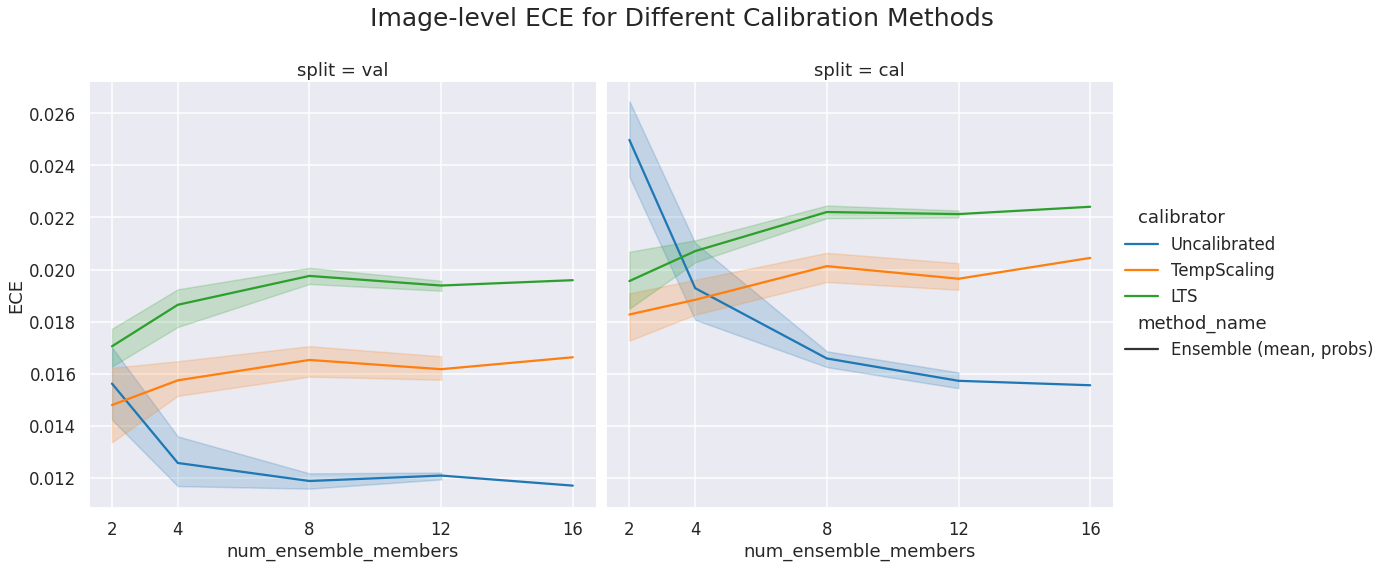

In [24]:
ece_metric_df = group_by_config(image_info_df[image_info_df['image_metric'] == 'Image_ECE'])

g = sns.relplot(
    data=ece_metric_df,
    x="num_ensemble_members",
    y="metric_score",
    hue="calibrator",
    style="method_name",
    kind="line",
    col="split",
    height=8,
)
# Set the title of the bar plot
g.fig.suptitle("Image-level ECE for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Set the y axis to be between 0.5 and 1.0
# calibrators_width = num_calibrators - 1
# Change the y axis label to say ECE
g.set_ylabels("ECE")
# Set the x ticks as 2, 4, 8, 12, 16
g.set(xticks=[2, 4, 8, 12, 16])

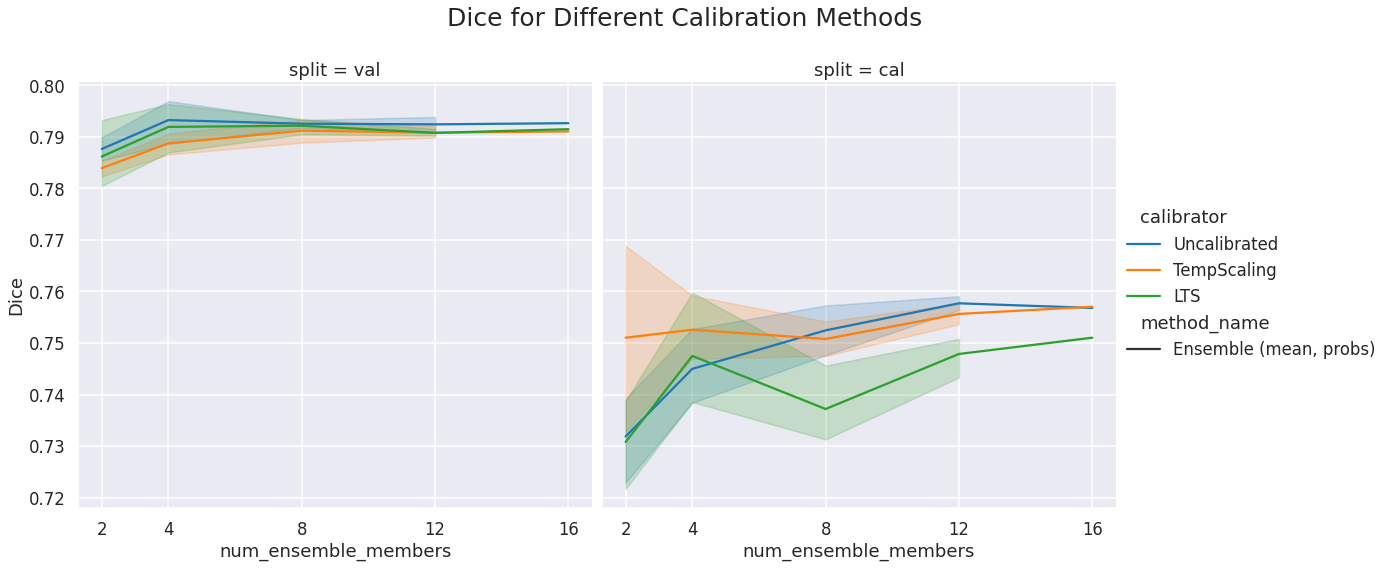

In [40]:
dice_metric_df = group_by_config(image_info_df[image_info_df['image_metric'] == 'Dice'])

g = sns.relplot(
    data=dice_metric_df,
    x="num_ensemble_members",
    y="metric_score",
    hue="calibrator",
    style="method_name",
    kind="line",
    col="split",
    height=8,
)
# Set the title of the bar plot
g.fig.suptitle("Dice for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Change the y axis label
g.set_ylabels("Dice")
# Set the x ticks as 2, 4, 8, 12, 16
g.set(xticks=[2, 4, 8, 12, 16])

In [26]:
dice_metric_df

,ensemble_hash,method_name,calibrator,split,num_ensemble_members,image_metric,metric_score
0,00a0da1434ba710dd208acc1eb3fd2dac72b48720279ec...,"Ensemble (mean, probs)",TempScaling,val,12,Dice,0.790638
1,00a0da1434ba710dd208acc1eb3fd2dac72b48720279ec...,"Ensemble (mean, probs)",TempScaling,cal,12,Dice,0.753793
2,00fbbaded96ee8335021d73d339e00400de4e28bc594a2...,"Ensemble (mean, probs)",LTS,val,4,Dice,0.800051
3,00fbbaded96ee8335021d73d339e00400de4e28bc594a2...,"Ensemble (mean, probs)",LTS,cal,4,Dice,0.744172
4,07ca6382c3bdb2b336a56194087f3092eb4c80b807aa8b...,"Ensemble (mean, probs)",LTS,val,4,Dice,0.795855
...,...,...,...,...,...,...,...
121,f99d5cd77b46684daa3cb7b7d34d3225fa16a970588328...,"Ensemble (mean, probs)",TempScaling,cal,4,Dice,0.757537
122,fb1869af4fede44dcaf34ac549ac540ef6c63bc2514e5e...,"Ensemble (mean, probs)",LTS,val,8,Dice,0.792235
123,fb1869af4fede44dcaf34ac549ac540ef6c63bc2514e5e...,"Ensemble (mean, probs)",LTS,cal,8,Dice,0.733935
124,fdf17b76282109d38b81e71b1722ba076374d6c647d6f8...,"Ensemble (mean, probs)",Uncalibrated,val,2,Dice,0.785000


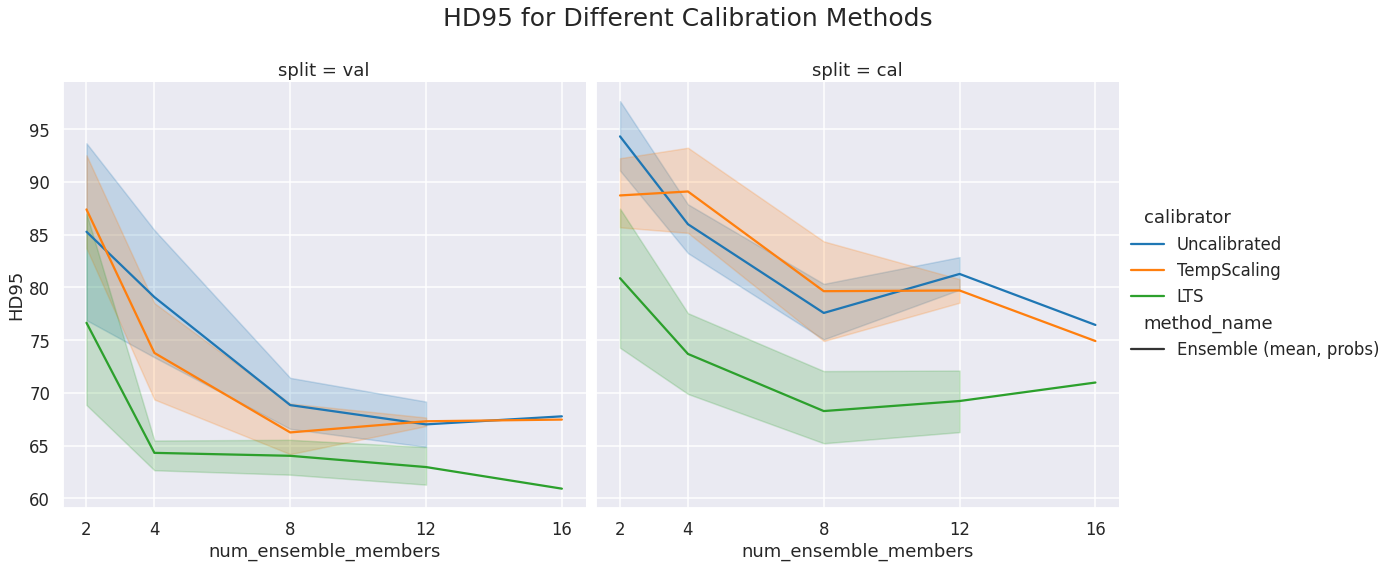

In [27]:
hd_metric_df = group_by_config(image_info_df[image_info_df['image_metric'] == 'HD95'])

g = sns.relplot(
    data=hd_metric_df,
    x="num_ensemble_members",
    y="metric_score",
    hue="calibrator",
    style="method_name",
    kind="line",
    col="split",
    height=8,
)
# Set the title of the bar plot
g.fig.suptitle("HD95 for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Change the y axis label
g.set_ylabels("HD95")
# Set the x ticks as 2, 4, 8, 12, 16
g.set(xticks=[2, 4, 8, 12, 16])

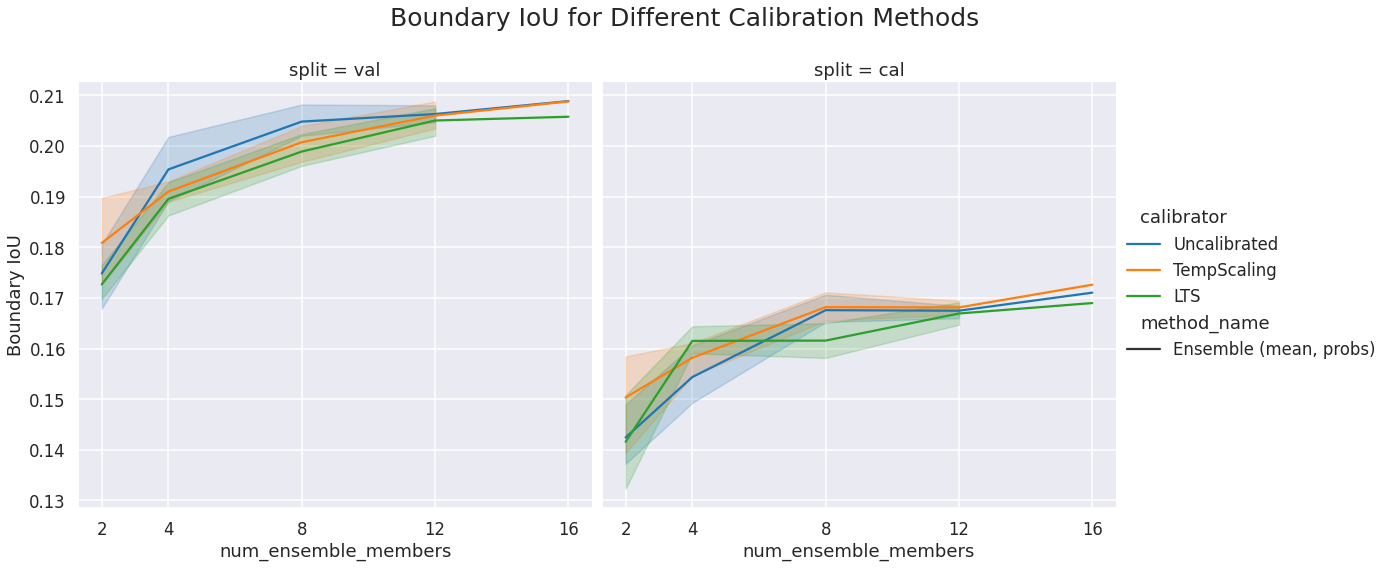

In [28]:
boundary_metric_df = group_by_config(image_info_df[image_info_df['image_metric'] == 'BoundaryIOU'])

g = sns.relplot(
    data=boundary_metric_df,
    x="num_ensemble_members",
    y="metric_score",
    hue="calibrator",
    style="method_name",
    kind="line",
    col="split",
    height=8,
)
# Set the title of the bar plot
g.fig.suptitle("Boundary IoU for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Change the y axis label
g.set_ylabels("Boundary IoU")
# Set the x ticks as 2, 4, 8, 12, 16
g.set(xticks=[2, 4, 8, 12, 16])

## Perf Per Size

In [29]:
# g = sns.relplot(
#     data=image_info_df[image_info_df["image_metric"] == "Image_ECE"],
#     x="num_lab_1_pixels",
#     y="metric_score",
#     hue="calibrator",
#     style="method_name",
#     col="split",
#     kind="line",
#     height=8,
#     palette="hls"
# )
# # Set the title of the bar plot
# g.fig.suptitle("Image-level ECE per Size for Different Calibration Methods", fontsize=25)
# # Give the title a bit of spacing from the plot
# g.fig.subplots_adjust(top=0.85)
# # Set the y axis to be between 0.5 and 1.0

In [30]:
# g = sns.relplot(
#     data=image_info_df[image_info_df["image_metric"] == "Dice"],
#     x="num_lab_1_pixels",
#     y="metric_score",
#     hue="calibrator",
#     style="method_name",
#     col="split",
#     kind="line",
#     height=8,
# )
# # Set the title of the bar plot
# g.fig.suptitle("Dice per Size for Different Calibration Methods", fontsize=25)
# # Give the title a bit of spacing from the plot
# g.fig.subplots_adjust(top=0.85)
# # Set the y axis to be between 0.5 and 1.0

In [31]:
# g = sns.relplot(
#     data=image_info_df[image_info_df["image_metric"] == "HD95"],
#     x="num_lab_1_pixels",
#     y="metric_score",
#     hue="calibrator",
#     style="method_name",
#     col="split",
#     kind="line",
#     height=8,
# )
# # Set the title of the bar plot
# g.fig.suptitle("HD95 per Size for Different Calibration Methods", fontsize=25)
# # Give the title a bit of spacing from the plot
# g.fig.subplots_adjust(top=0.85)
# # Set the y axis to be between 0.5 and 1.0

In [32]:
# g = sns.relplot(
#     data=image_info_df[image_info_df["image_metric"] == "BoundaryIOU"],
#     x="num_lab_1_pixels",
#     y="metric_score",
#     hue="calibrator",
#     style="method_name",
#     col="split",
#     kind="line",
#     height=8,
# )
# # Set the title of the bar plot
# g.fig.suptitle("BoundaryIOU per Size for Different Calibration Methods", fontsize=25)
# # Give the title a bit of spacing from the plot
# g.fig.subplots_adjust(top=0.85)
# # Set the y axis to be between 0.5 and 1.0

# Looking at Ensemble Variance Under Different Definitions

In [33]:
# ensemble_info_df = image_info_df[image_info_df['method_name'] != "Average UNet"]

In [34]:
# g = sns.catplot(
#     data=ensemble_info_df[ensemble_info_df["image_metric"] == "Avg-PW Soft-Dice"],
#     x="calibrator",
#     y="metric_score",
#     col="split",
#     kind="bar",
#     height=8,
#     aspect=3,
# )
# # Set the title of the bar plot
# g.fig.suptitle("Average Pairwise Soft Dice for Different Calibration Methods", fontsize=25)
# # Give the title a bit of spacing from the plot
# g.fig.subplots_adjust(top=0.85)
# # Set the y axis to be between 0.5 and 1.0
# calibrators_width = num_calibrators - 1
# g.set(xlim=(-0.8, calibrators_width + 0.8))
# # g.set(ylim=(0.8, 1.0))

In [35]:
# g = sns.catplot(
#     data=ensemble_info_df[ensemble_info_df["image_metric"] == "Avg-PW Hard-Dice"],
#     x="calibrator",
#     y="metric_score",
#     col="split",
#     kind="bar",
#     height=8,
#     aspect=3,
# )
# # Set the title of the bar plot
# g.fig.suptitle("Average Pairwise Hard Dice for Different Calibration Methods", fontsize=25)
# # Give the title a bit of spacing from the plot
# g.fig.subplots_adjust(top=0.85)
# # Set the y axis to be between 0.5 and 1.0
# calibrators_width = num_calibrators - 1
# g.set(xlim=(-0.8, calibrators_width + 0.8))
# # g.set(ylim=(0.8, 1.0))

In [36]:
# g = sns.catplot(
#     data=ensemble_info_df[ensemble_info_df["image_metric"] == "Ensemble-VAR"],
#     x="calibrator",
#     y="metric_score",
#     col="split",
#     kind="bar",
#     height=8,
#     aspect=3,
# )
# # Set the title of the bar plot
# g.fig.suptitle("Ensemble Variance Pixel-Probs for Different Calibration Methods", fontsize=25)
# # Give the title a bit of spacing from the plot
# g.fig.subplots_adjust(top=0.85)
# # Set the y axis to be between 0.5 and 1.0
# calibrators_width = num_calibrators - 1
# g.set(xlim=(-0.8, calibrators_width + 0.8))
# # g.set(ylim=(0.8, 1.0))

In [37]:
# g = sns.catplot(
#     data=ensemble_info_df[ensemble_info_df["image_metric"] == "Ambiguity"],
#     x="calibrator",
#     y="metric_score",
#     col="split",
#     kind="bar",
#     height=8,
#     aspect=3,
# )
# # Set the title of the bar plot
# g.fig.suptitle("Pixel-wise Ensemble Ambiguity for Different Calibration Methods", fontsize=25)
# # Give the title a bit of spacing from the plot
# g.fig.subplots_adjust(top=0.85)
# # Set the y axis to be between 0.5 and 1.0
# calibrators_width = num_calibrators - 1
# g.set(xlim=(-0.8, calibrators_width + 0.8))
# # g.set(ylim=(0.0, 0.015))